In [1]:
#import
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np
import matplotlib.pyplot as plt
from grid_world import standard_grid, negative_grid
from iterative_policy_evaluation import print_values, print_policy
from monte_carlo_es import max_dict
from sarsa import random_action, GAMMA, ALPHA, ALL_POSSIBLE_ACTIONS

SA2IDX = {}
IDX = 0

In [2]:
#Define Model
class Model:
  def __init__(self):
    self.theta = np.random.randn(25) / np.sqrt(25)
    # if we use SA2IDX, a one-hot encoding for every (s,a) pair
    # in reality we wouldn't want to do this b/c we have just
    # as many params as before
    # print "D:", IDX
    # self.theta = np.random.randn(IDX) / np.sqrt(IDX)

  def sa2x(self, s, a):
    # NOTE: using just (r, c, r*c, u, d, l, r, 1) is not expressive enough
    return np.array([
      s[0] - 1              if a == 'U' else 0,
      s[1] - 1.5            if a == 'U' else 0,
      (s[0]*s[1] - 3)/3     if a == 'U' else 0,
      (s[0]*s[0] - 2)/2     if a == 'U' else 0,
      (s[1]*s[1] - 4.5)/4.5 if a == 'U' else 0,
      1                     if a == 'U' else 0,
      s[0] - 1              if a == 'D' else 0,
      s[1] - 1.5            if a == 'D' else 0,
      (s[0]*s[1] - 3)/3     if a == 'D' else 0,
      (s[0]*s[0] - 2)/2     if a == 'D' else 0,
      (s[1]*s[1] - 4.5)/4.5 if a == 'D' else 0,
      1                     if a == 'D' else 0,
      s[0] - 1              if a == 'L' else 0,
      s[1] - 1.5            if a == 'L' else 0,
      (s[0]*s[1] - 3)/3     if a == 'L' else 0,
      (s[0]*s[0] - 2)/2     if a == 'L' else 0,
      (s[1]*s[1] - 4.5)/4.5 if a == 'L' else 0,
      1                     if a == 'L' else 0,
      s[0] - 1              if a == 'R' else 0,
      s[1] - 1.5            if a == 'R' else 0,
      (s[0]*s[1] - 3)/3     if a == 'R' else 0,
      (s[0]*s[0] - 2)/2     if a == 'R' else 0,
      (s[1]*s[1] - 4.5)/4.5 if a == 'R' else 0,
      1                     if a == 'R' else 0,
      1
    ])
    # if we use SA2IDX, a one-hot encoding for every (s,a) pair
    # in reality we wouldn't want to do this b/c we have just
    # as many params as before
    # x = np.zeros(len(self.theta))
    # idx = SA2IDX[s][a]
    # x[idx] = 1
    # return x

  def predict(self, s, a):
    x = self.sa2x(s, a)
    return self.theta.dot(x)

  def grad(self, s, a):
    return self.sa2x(s, a)

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|
it: 0
it: 1000
it: 2000
it: 3000
it: 4000
it: 5000
it: 6000
it: 7000
it: 8000
it: 9000
it: 10000
it: 11000
it: 12000
it: 13000
it: 14000
it: 15000
it: 16000
it: 17000
it: 18000
it: 19000


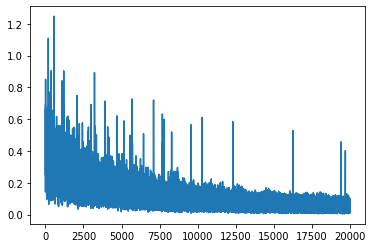

values:
---------------------------
 0.44| 0.69| 0.98| 0.00|
---------------------------
 0.35| 0.00| 0.53| 0.00|
---------------------------
 0.17| 0.03| 0.14| 0.54|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  L  |  L  |  U  |


In [3]:
def getQs(model, s):
  # we need Q(s,a) to choose an action
  # i.e. a = argmax[a]{ Q(s,a) }
  Qs = {}
  for a in ALL_POSSIBLE_ACTIONS:
    q_sa = model.predict(s, a)
    Qs[a] = q_sa
  return Qs


if __name__ == '__main__':
  # NOTE: if we use the standard grid, there's a good chance we will end up with
  # suboptimal policies
  # e.g.
  # ---------------------------
  #   R  |   R  |   R  |      |
  # ---------------------------
  #   R* |      |   U  |      |
  # ---------------------------
  #   U  |   R  |   U  |   L  |
  # since going R at (1,0) (shown with a *) incurs no cost, it's OK to keep doing that.
  # we'll either end up staying in the same spot, or back to the start (2,0), at which
  # point we whould then just go back up, or at (0,0), at which point we can continue
  # on right.
  # instead, let's penalize each movement so the agent will find a shorter route.
  #
  # grid = standard_grid()
  grid = negative_grid(step_cost=-0.1)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # no policy initialization, we will derive our policy from most recent Q
  # enumerate all (s,a) pairs, each will have its own weight in our "dumb" model
  # essentially each weight will be a measure of Q(s,a) itself
  states = grid.all_states()
  for s in states:
    SA2IDX[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      SA2IDX[s][a] = IDX
      IDX += 1

  # initialize model
  model = Model()

  # repeat until convergence
  t = 1.0
  t2 = 1.0
  deltas = []
  for it in range(20000):
    if it % 100 == 0:
      t += 0.01
      t2 += 0.01
    if it % 1000 == 0:
      print("it:", it)
    alpha = ALPHA / t2

    # instead of 'generating' an epsiode, we will PLAY
    # an episode within this loop
    s = (2, 0) # start state
    grid.set_state(s)

    # get Q(s) so we can choose the first action
    Qs = getQs(model, s)

    # the first (s, r) tuple is the state we start in and 0
    # (since we don't get a reward) for simply starting the game
    # the last (s, r) tuple is the terminal state and the final reward
    # the value for the terminal state is by definition 0, so we don't
    # care about updating it.
    a = max_dict(Qs)[0]
    a = random_action(a, eps=0.5/t) # epsilon-greedy
    biggest_change = 0
    while not grid.game_over():
      r = grid.move(a)
      s2 = grid.current_state()

      # we need the next action as well since Q(s,a) depends on Q(s',a')
      # if s2 not in policy then it's a terminal state, all Q are 0
      old_theta = model.theta.copy()
      if grid.is_terminal(s2):
        model.theta += alpha*(r - model.predict(s, a))*model.grad(s, a)
      else:
        # not terminal
        Qs2 = getQs(model, s2)
        a2 = max_dict(Qs2)[0]
        a2 = random_action(a2, eps=0.5/t) # epsilon-greedy

        # we will update Q(s,a) AS we experience the episode
        model.theta += alpha*(r + GAMMA*model.predict(s2, a2) - model.predict(s, a))*model.grad(s, a)
        
        # next state becomes current state
        s = s2
        a = a2

      biggest_change = max(biggest_change, np.abs(model.theta - old_theta).sum())
    deltas.append(biggest_change)

  plt.plot(deltas)
  plt.show()

  # determine the policy from Q*
  # find V* from Q*
  policy = {}
  V = {}
  Q = {}
  for s in grid.actions.keys():
    Qs = getQs(model, s)
    Q[s] = Qs
    a, max_q = max_dict(Qs)
    policy[s] = a
    V[s] = max_q

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

#### Sarsa

In [4]:
#import
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np
import matplotlib.pyplot as plt
from grid_world import standard_grid, negative_grid
from iterative_policy_evaluation import print_values, print_policy
from monte_carlo_es import max_dict
from td0_prediction import random_action

GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|
it: 0
it: 2000
it: 4000
it: 6000
it: 8000


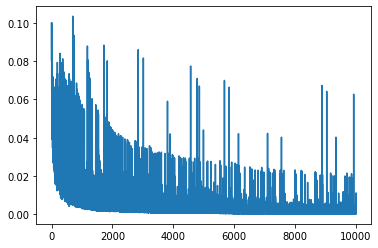

update counts:
---------------------------
 0.18| 0.18| 0.18| 0.00|
---------------------------
 0.19| 0.00| 0.04| 0.00|
---------------------------
 0.19| 0.02| 0.02| 0.00|
values:
---------------------------
 0.50| 0.72| 1.00| 0.00|
---------------------------
 0.30| 0.00| 0.72| 0.00|
---------------------------
 0.13| 0.18| 0.37| 0.14|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |


In [5]:
#main
if __name__ == '__main__':
  # NOTE: if we use the standard grid, there's a good chance we will end up with
  # suboptimal policies
  # e.g.
  # ---------------------------
  #   R  |   R  |   R  |      |
  # ---------------------------
  #   R* |      |   U  |      |
  # ---------------------------
  #   U  |   R  |   U  |   L  |
  # since going R at (1,0) (shown with a *) incurs no cost, it's OK to keep doing that.
  # we'll either end up staying in the same spot, or back to the start (2,0), at which
  # point we whould then just go back up, or at (0,0), at which point we can continue
  # on right.
  # instead, let's penalize each movement so the agent will find a shorter route.
  #
  # grid = standard_grid()
  grid = negative_grid(step_cost=-0.1)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # no policy initialization, we will derive our policy from most recent Q

  # initialize Q(s,a)
  Q = {}
  states = grid.all_states()
  for s in states:
    Q[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      Q[s][a] = 0

  # let's also keep track of how many times Q[s] has been updated
  update_counts = {}
  update_counts_sa = {}
  for s in states:
    update_counts_sa[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      update_counts_sa[s][a] = 1.0

  # repeat until convergence
  t = 1.0
  deltas = []
  for it in range(10000):
    if it % 100 == 0:
      t += 1e-2
    if it % 2000 == 0:
      print("it:", it)

    # instead of 'generating' an epsiode, we will PLAY
    # an episode within this loop
    s = (2, 0) # start state
    grid.set_state(s)

    # the first (s, r) tuple is the state we start in and 0
    # (since we don't get a reward) for simply starting the game
    # the last (s, r) tuple is the terminal state and the final reward
    # the value for the terminal state is by definition 0, so we don't
    # care about updating it.
    a = max_dict(Q[s])[0]
    a = random_action(a, eps=0.5/t)
    biggest_change = 0
    while not grid.game_over():
      r = grid.move(a)
      s2 = grid.current_state()

      # we need the next action as well since Q(s,a) depends on Q(s',a')
      # if s2 not in policy then it's a terminal state, all Q are 0
      a2 = max_dict(Q[s2])[0]
      a2 = random_action(a2, eps=0.5/t) # epsilon-greedy

      # we will update Q(s,a) AS we experience the episode
      alpha = ALPHA / update_counts_sa[s][a]
      update_counts_sa[s][a] += 0.005
      old_qsa = Q[s][a]
      Q[s][a] = Q[s][a] + alpha*(r + GAMMA*Q[s2][a2] - Q[s][a])
      biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

      # we would like to know how often Q(s) has been updated too
      update_counts[s] = update_counts.get(s,0) + 1

      # next state becomes current state
      s = s2
      a = a2

    deltas.append(biggest_change)

  plt.plot(deltas)
  plt.show()

  # determine the policy from Q*
  # find V* from Q*
  policy = {}
  V = {}
  for s in grid.actions.keys():
    a, max_q = max_dict(Q[s])
    policy[s] = a
    V[s] = max_q

  # what's the proportion of time we spend updating each part of Q?
  print("update counts:")
  total = np.sum(list(update_counts.values()))
  for k, v in update_counts.items():
    update_counts[k] = float(v) / total
  print_values(update_counts, grid)

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

#### TD0 Prediction

In [6]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np
import matplotlib.pyplot as plt
from grid_world import standard_grid, negative_grid
from iterative_policy_evaluation import print_values, print_policy

SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

In [7]:
# NOTE: this is only policy evaluation, not optimization

def random_action(a, eps=0.1):
  # we'll use epsilon-soft to ensure all states are visited
  # what happens if you don't do this? i.e. eps=0
  p = np.random.random()
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

def play_game(grid, policy):
  # returns a list of states and corresponding rewards (not returns as in MC)
  # start at the designated start state
  s = (2, 0)
  grid.set_state(s)
  states_and_rewards = [(s, 0)] # list of tuples of (state, reward)
  while not grid.game_over():
    a = policy[s]
    a = random_action(a)
    r = grid.move(a)
    s = grid.current_state()
    states_and_rewards.append((s, r))
  return states_and_rewards


if __name__ == '__main__':
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  grid = standard_grid()

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'R',
    (2, 3): 'U',
  }

  # initialize V(s) and returns
  V = {}
  states = grid.all_states()
  for s in states:
    V[s] = 0

  # repeat until convergence
  for it in range(1000):

    # generate an episode using pi
    states_and_rewards = play_game(grid, policy)
    # the first (s, r) tuple is the state we start in and 0
    # (since we don't get a reward) for simply starting the game
    # the last (s, r) tuple is the terminal state and the final reward
    # the value for the terminal state is by definition 0, so we don't
    # care about updating it.
    for t in range(len(states_and_rewards) - 1):
      s, _ = states_and_rewards[t]
      s2, r = states_and_rewards[t+1]
      # we will update V(s) AS we experience the episode
      V[s] = V[s] + ALPHA*(r + GAMMA*V[s2] - V[s])

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)

rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
values:
---------------------------
 0.74| 0.81| 0.92| 0.00|
---------------------------
 0.66| 0.00|-0.83| 0.00|
---------------------------
 0.59|-0.20|-0.49|-0.85|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  U  |
